# Preparing the data

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob

def findFiles(path):
    return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + ".,;"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )


print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines =open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = filename.split('/')[-1].split(".")[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    
n_categories = len(all_categories)

print(category_lines["French"][:5])

[u'data/names/Irish.txt', u'data/names/French.txt', u'data/names/Japanese.txt', u'data/names/German.txt', u'data/names/Vietnamese.txt', u'data/names/Dutch.txt', u'data/names/Polish.txt', u'data/names/Spanish.txt', u'data/names/Czech.txt', u'data/names/English.txt', u'data/names/Arabic.txt', u'data/names/Korean.txt', u'data/names/Greek.txt', u'data/names/Russian.txt', u'data/names/Chinese.txt', u'data/names/Portuguese.txt', u'data/names/Italian.txt', u'data/names/Scottish.txt']
Slusarski
[u'Abel', u'Abraham', u'Adam', u'Albert', u'Allard']


# Turning names into Tensors

In [2]:
import torch

In [3]:
# Find letter index from all_letters. e.g "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

#Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

#Turn a line into a <line_length x 1 x n_letters>
# of an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print( letterToTensor('J'))
print(lineToTensor("Jones").size())



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 13 to 25 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 26 to 38 
    0     0     0     0     0     0     0     0     0     1     0     0     0

Columns 39 to 51 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 52 to 54 
    0     0     0
[torch.FloatTensor of size 1x55]

torch.Size([5, 1, 55])


# Creating the Network

In [4]:
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

In [5]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.i2h1 = nn.Linear(input_size + hidden_size, input_size + hidden_size)
        self.i2h2 = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax()
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h2(F.relu(self.i2h1(combined)))
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return Variable(torch.zeros(1, self.hidden_size))
    
n_hidden = 64
rnn = RNN(n_letters, n_hidden, n_categories)


In [6]:
input = Variable(letterToTensor('A'))
hidden = Variable(torch.zeros(1, n_hidden))

output, next_hidden = rnn(input, hidden)

In [7]:
input = Variable(lineToTensor('Albert'))
hidden = Variable(torch.zeros(1, n_hidden))

output, next_hidden = rnn(input[0], hidden)
print(output)

Variable containing:

Columns 0 to 9 
-2.9124 -2.8498 -2.8680 -3.0422 -2.8734 -2.7943 -2.8588 -2.9053 -2.9848 -2.8860

Columns 10 to 17 
-2.9266 -2.9221 -2.8851 -2.9686 -2.8122 -2.9096 -2.7553 -2.9113
[torch.FloatTensor of size 1x18]



# Training


## Preparing for training

In [8]:
def categoryFromOutput(output):
    top_n, top_i = output.data.topk(1)
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

(u'Italian', 16)


In [9]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l)-1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(lineToTensor(line))
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category=', category, '/ line =', line)

category= Vietnamese / line = Phi
category= Russian / line = Talmin
category= Italian / line = Profeta
category= Greek / line = Egonidis
category= Korean / line = Chweh
category= Korean / line = Si
category= Portuguese / line = Abreu
category= Chinese / line = Zhuo
category= Dutch / line = Muyskens
category= Arabic / line = Maalouf


## Training the network

In [10]:
criterion = nn.NLLLoss()

In [11]:
learning_rate = 0.005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    loss = criterion(output, category_tensor)
    loss.backward()
    
    #Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(- learning_rate, p.grad.data)
    
    return output, loss.data[0]

In [12]:
import time
import math

In [13]:
n_iters = 100000
print_every = 5000
plot_every = 1000

In [14]:
# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    # Print iter number, loss name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct =  '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))
    
    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0


5000 5% (0m 22s) 2.7254 Trang / Korean ✗ (Vietnamese)
10000 10% (0m 40s) 1.3622 Karnoupakis / Greek ✓
15000 15% (0m 57s) 1.7182 Voltolini / Italian ✓
20000 20% (1m 15s) 2.3630 ONeal / Arabic ✗ (Irish)
25000 25% (1m 34s) 2.5927 Nazari / Japanese ✗ (Arabic)
30000 30% (1m 56s) 1.8489 Murphy / Irish ✓
35000 35% (2m 15s) 2.4572 Martell / Dutch ✗ (Spanish)
40000 40% (2m 32s) 1.0770 Anderson / Scottish ✓
45000 45% (2m 50s) 0.2340 Glynatsis / Greek ✓
50000 50% (3m 8s) 3.1347 Ciardha / Spanish ✗ (Irish)
55000 55% (3m 26s) 1.3686 Sarraf / Arabic ✓
60000 60% (3m 43s) 0.0703 Motoyoshi / Japanese ✓
65000 65% (4m 1s) 1.2827 Maria / Portuguese ✓
70000 70% (4m 19s) 3.4829 Monomonoi / Greek ✗ (Japanese)
75000 75% (4m 36s) 0.7395 Sarkis / Arabic ✓
80000 80% (4m 54s) 1.6382 Hoffmann / Irish ✗ (German)
85000 85% (5m 12s) 1.4589 Cruz / Spanish ✗ (Portuguese)
90000 90% (5m 30s) 2.1307 Duval / Irish ✗ (French)
95000 95% (5m 53s) 0.6660 Kolen / Dutch ✓
100000 100% (6m 11s) 0.8740 Koo / Korean ✓


## Plotting the results

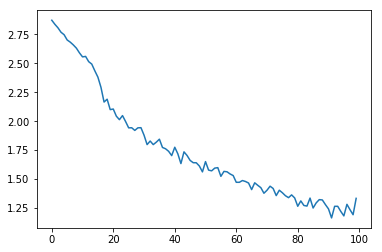

In [15]:
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker


plt.plot(all_losses)
plt.show()

from init_func import *


clf = MultiInitialisationClassifier(rnn)
clf.fit()


## Evaluating the results

In [16]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

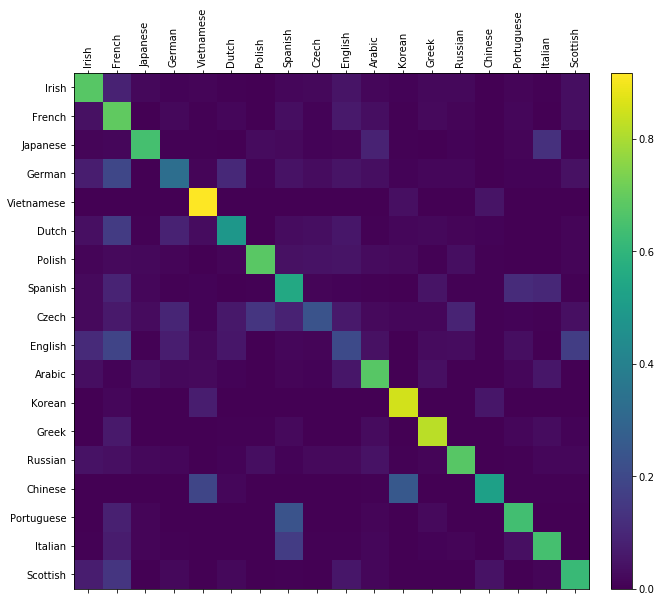

In [17]:
# Keep track of the correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    return output
    
# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1
    
# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()
    
# Set up plot 
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(111)
im = ax.matshow(confusion.numpy())
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size = "4%", pad = 0.3)
fig.colorbar(im, cax=cax)

# Set up axes 
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [22]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    output = evaluate(Variable(lineToTensor(input_line)))
    
    # Get top N categories
    topv, topi = output.data.topk(n_predictions, 1, True)
    predictions = []
    
    for i in range(n_predictions):
        value = math.exp(topv[0][i])
        category_index = topi[0][i]
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])
        
predict('Dovesky')
predict('Jackson')
predict('Satoshi')
    
    


> Dovesky
(0.68) Russian
(0.16) Polish
(0.13) Czech

> Jackson
(0.98) Scottish
(0.01) English
(0.01) Russian

> Satoshi
(0.50) Arabic
(0.18) Japanese
(0.14) Italian


In [23]:
predict("Begotto")
predict("Leone")
predict("Piriou")
predict("Hollocoux")
predict("DaCosta")


> Begotto
(0.36) Italian
(0.31) Portuguese
(0.26) Spanish

> Leone
(0.52) French
(0.11) Italian
(0.11) Irish

> Piriou
(0.53) French
(0.12) Spanish
(0.07) English

> Hollocoux
(0.40) Russian
(0.39) French
(0.05) Greek

> DaCosta
(0.39) Spanish
(0.21) Portuguese
(0.14) Czech


In [24]:
predict("Chiche")


> Chiche
(0.22) Japanese
(0.20) Irish
(0.11) English


In [21]:
predict("")


> 


IndexError: tuple index out of range

In [25]:
predict("Marcotte")


> Marcotte
(0.30) Italian
(0.22) French
(0.11) German
